# Setup

In [27]:
%%capture
import scanpy as sc
import pandas as pd
import scrnatools as rna
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import scvi
import scipy
from scipy.stats import spearmanr

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [3]:
os.getcwd()

'/home/joe/Repositories/Thymic-B-cells/code'

## Set data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## import data

In [20]:
adata = sc.read(f"{processedDataPath}/Thymic_B_cells/h5ad_files/CCR6_WT_KO_B_cells.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/Thymic_B_cells/scVI_models/CCR6_WT_KO_B_cells", adata=adata)
TFs = list(pd.read_csv("../mouse_ensemble_tfs_from_lambertetal_isyes.unique.csv", header=None)[1])
TFs = [i for i in TFs if i in adata.var_names]

INFO     File /mnt/iacchus/joe/processed_data//Thymic_B_cells/scVI_models/CCR6_WT_KO_B_cells/model.pt already      
         downloaded                                                                                                


## Methods

### plot gene list

In [7]:
def plot_gene_list(adata, gene_list, layer, obs_key=None, obs_list=None, save_path=None, *arg, **kwarg):
    vmin = []
    vmax = []
    for gene in gene_list:
        if obs_key is None:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[:, gene].layers[layer].todense())
            else:
                data = adata[:, gene].layers[layer]
        else:
            if scipy.sparse.issparse(adata.layers[layer]):
                data = np.asarray(adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer].todense())
            else:
                data = adata[adata.obs[obs_key] == obs_list[0], gene].layers[layer]
        vmin.append(np.quantile(data, 0.01))
        vmax.append(np.quantile(data, 0.99))
    
    if save_path is not None:
        sc.settings.figdir = save_path.rsplit("/", 1)[0]
        file = save_path.rsplit("/", 1)[1]
    else:
        file=None
    if obs_key is None:
        sc.pl.umap(
            adata,
            color=gene_list,
            layer=layer,
            vmin=vmin,
            vmax=vmax,
            save=file,
            *arg, **kwarg
        )
    else:
        for obs in obs_list:
            sc.pl.umap(
                adata[adata.obs[obs_key] == obs],
                color=gene_list,
                layer=layer,
                vmin=vmin,
                vmax=vmax,
                save=f"{file}_{obs}.pdf",
                *arg, **kwarg
            )

### genotype gene expression

In [8]:
def genotype_gene_expression(
    adata, gene_list, genotype_list, highlight_genes, label_genes=[],
    cell_type_list=None, save_path=None, axis_lim=[10**-2, 10**2],
    figdim=(5.5,5),
):
    copy_adata = adata[:, gene_list]
        
    expression = pd.DataFrame(
        copy_adata.layers["scVI_normalized"],
        index=copy_adata.obs.index,
        columns=copy_adata.var_names
    )
    expression["genotype"] = copy_adata.obs.genotype
    expression = expression.groupby("genotype").mean().T
    plt.figure(figsize=figdim)
    sns.scatterplot(
        expression,
        y=expression[genotype_list[0]],
        x=expression[genotype_list[1]],
        linewidth=0,
        s=8,
        color="lightgrey"
    )
    highlightExpression = expression[(expression.index.isin(highlight_genes)) & (expression[genotype_list[1]] > expression[genotype_list[0]])]
    ax = sns.scatterplot(
        highlightExpression,
        y=highlightExpression[genotype_list[0]],
        x=highlightExpression[genotype_list[1]],
        linewidth=0,
        s=8,
        color="tab:red"
    )
    highlightExpression = expression[(expression.index.isin(highlight_genes)) & (expression[genotype_list[1]] < expression[genotype_list[0]])]
    ax = sns.scatterplot(
        highlightExpression,
        y=highlightExpression[genotype_list[0]],
        x=highlightExpression[genotype_list[1]],
        linewidth=0,
        s=8,
        color="tab:green"
    )
    for gene in label_genes:
        ax.text(
            y=expression[expression.index==gene][genotype_list[0]],
            x=expression[expression.index==gene][genotype_list[1]],
            s=gene,
            fontsize=12,
            color="blue"
        )
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", linestyle="dashed")
    ax.grid(False)
    plt.xlim(axis_lim[0], axis_lim[1])
    plt.ylim(axis_lim[0], axis_lim[1])
    plt.xscale("log")
    plt.yscale("log")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

### Volcano plot method

In [9]:
def volcano_plot(de, highlight_genes, label_genes=[], highlight_color="red", save_path=None):
    ax = sns.scatterplot(
        x=de.lfc_mean,
        y=de.bayes_factor,
        linewidth=0,
        s=5,
        color="lightgrey",
    )
    ax.grid(False)
    ax.set(xlabel='lfc_mean_WT_vs_KO')
    sns.scatterplot(
        x=de[de.index.isin(highlight_genes)].lfc_mean,
        y=de[de.index.isin(highlight_genes)].bayes_factor,
        linewidth=0,
        s=5,
        color=highlight_color,
    )
    plt.axhline(y=2, color="black", linestyle="dashed")
    plt.axvline(x=-1, color="black", linestyle="dashed")
    plt.axvline(x=1, color="black", linestyle="dashed")
    for gene in label_genes:
        plt.text(
            de[de.index == gene].lfc_mean,
            de[de.index == gene].bayes_factor,
            s=gene,
            color="tab:blue",
            fontdict={"fontsize":12},
        )
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Whole dataset DE genes

In [10]:
allClustersDE = model.differential_expression(
    groupby="batch",
    group1="WT",
    group2="CCR6_KO"
)

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


## Filter highly DE genes

In [11]:
filteredAllClustersDE = allClustersDE[allClustersDE.bayes_factor > 2].copy()
filteredAllClustersDE = filteredAllClustersDE[abs(filteredAllClustersDE.lfc_mean) > 1]
filteredAllClustersDE = filteredAllClustersDE[(filteredAllClustersDE.non_zeros_proportion1 > 0.05) | (filteredAllClustersDE.non_zeros_proportion2 > 0.05)]

In [12]:
# Filter genes with low average normalized expression
expressionFiltered = pd.DataFrame(
    pd.DataFrame(
        adata[:, filteredAllClustersDE.index].layers["scVI_normalized"],
        columns=filteredAllClustersDE.index
    ).quantile(0.99)
)
expressionFiltered = expressionFiltered[expressionFiltered[0.99] > 1]
filteredAllClustersDE = filteredAllClustersDE[filteredAllClustersDE.index.isin(expressionFiltered.index)]

## Save CSVs

In [14]:
allClustersDE.to_csv("../analysis/CCR6_WT_vs_KO_DE/all_clusters.csv")
filteredAllClustersDE.to_csv("../analysis/CCR6_WT_vs_KO_DE/all_clusters_filtered.csv")

# Feature plots

In [48]:
filteredAllClustersDE = filteredAllClustersDE.sort_values(by="lfc_mean", ascending=False)
filteredAllClustersDE

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Fgfr2,0.9992,0.0008,7.130086,0.000466,0.000088,0.0,0.25,2.443276,2.455295,0.598285,...,2.912955,0.688353,0.811896,0.394862,4.281539,0.792115,True,WT vs CCR6_KO,WT,CCR6_KO
Gm21887,0.9922,0.0078,4.845800,0.000131,0.000027,0.0,0.25,2.266088,2.276162,0.742502,...,0.915385,0.221352,0.505319,0.167513,1.401340,0.257835,True,WT vs CCR6_KO,WT,CCR6_KO
Gm48099,0.9956,0.0044,5.421739,0.000528,0.000119,0.0,0.25,2.190176,2.198822,0.765097,...,3.509665,0.901707,0.844294,0.470082,5.065567,1.121460,True,WT vs CCR6_KO,WT,CCR6_KO
Gm19951,0.9938,0.0062,5.076985,0.000850,0.000220,0.0,0.25,1.967834,1.974810,0.712539,...,5.974825,1.725556,0.923114,0.656207,8.651220,2.240383,True,WT vs CCR6_KO,WT,CCR6_KO
Hist1h2ap,0.9656,0.0344,3.334693,0.000026,0.000010,0.0,0.25,1.925010,2.131939,1.491614,...,0.234526,0.130442,0.108801,0.049685,0.245116,0.078607,True,WT vs CCR6_KO,WT,CCR6_KO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mybl2,0.9288,0.0712,2.568400,0.000003,0.000012,0.0,0.25,-1.696114,-1.653646,2.274909,...,0.020309,0.134133,0.013540,0.066451,0.012923,0.073543,False,WT vs CCR6_KO,WT,CCR6_KO
Ramp1,0.9234,0.0766,2.489465,0.000006,0.000024,0.0,0.25,-1.724136,-1.651828,2.015949,...,0.024662,0.124750,0.008704,0.051992,0.018190,0.103511,False,WT vs CCR6_KO,WT,CCR6_KO
Lyz2,0.9424,0.0576,2.794907,0.000050,0.000143,0.0,0.25,-2.036101,-1.954467,2.804067,...,0.883462,1.635284,0.016925,0.073989,0.817546,1.527200,True,WT vs CCR6_KO,WT,CCR6_KO
Ifitm2,0.9540,0.0460,3.032022,0.000008,0.000032,0.0,0.25,-2.632979,-2.599391,2.673764,...,0.075919,0.181818,0.013056,0.053684,0.057681,0.194966,True,WT vs CCR6_KO,WT,CCR6_KO


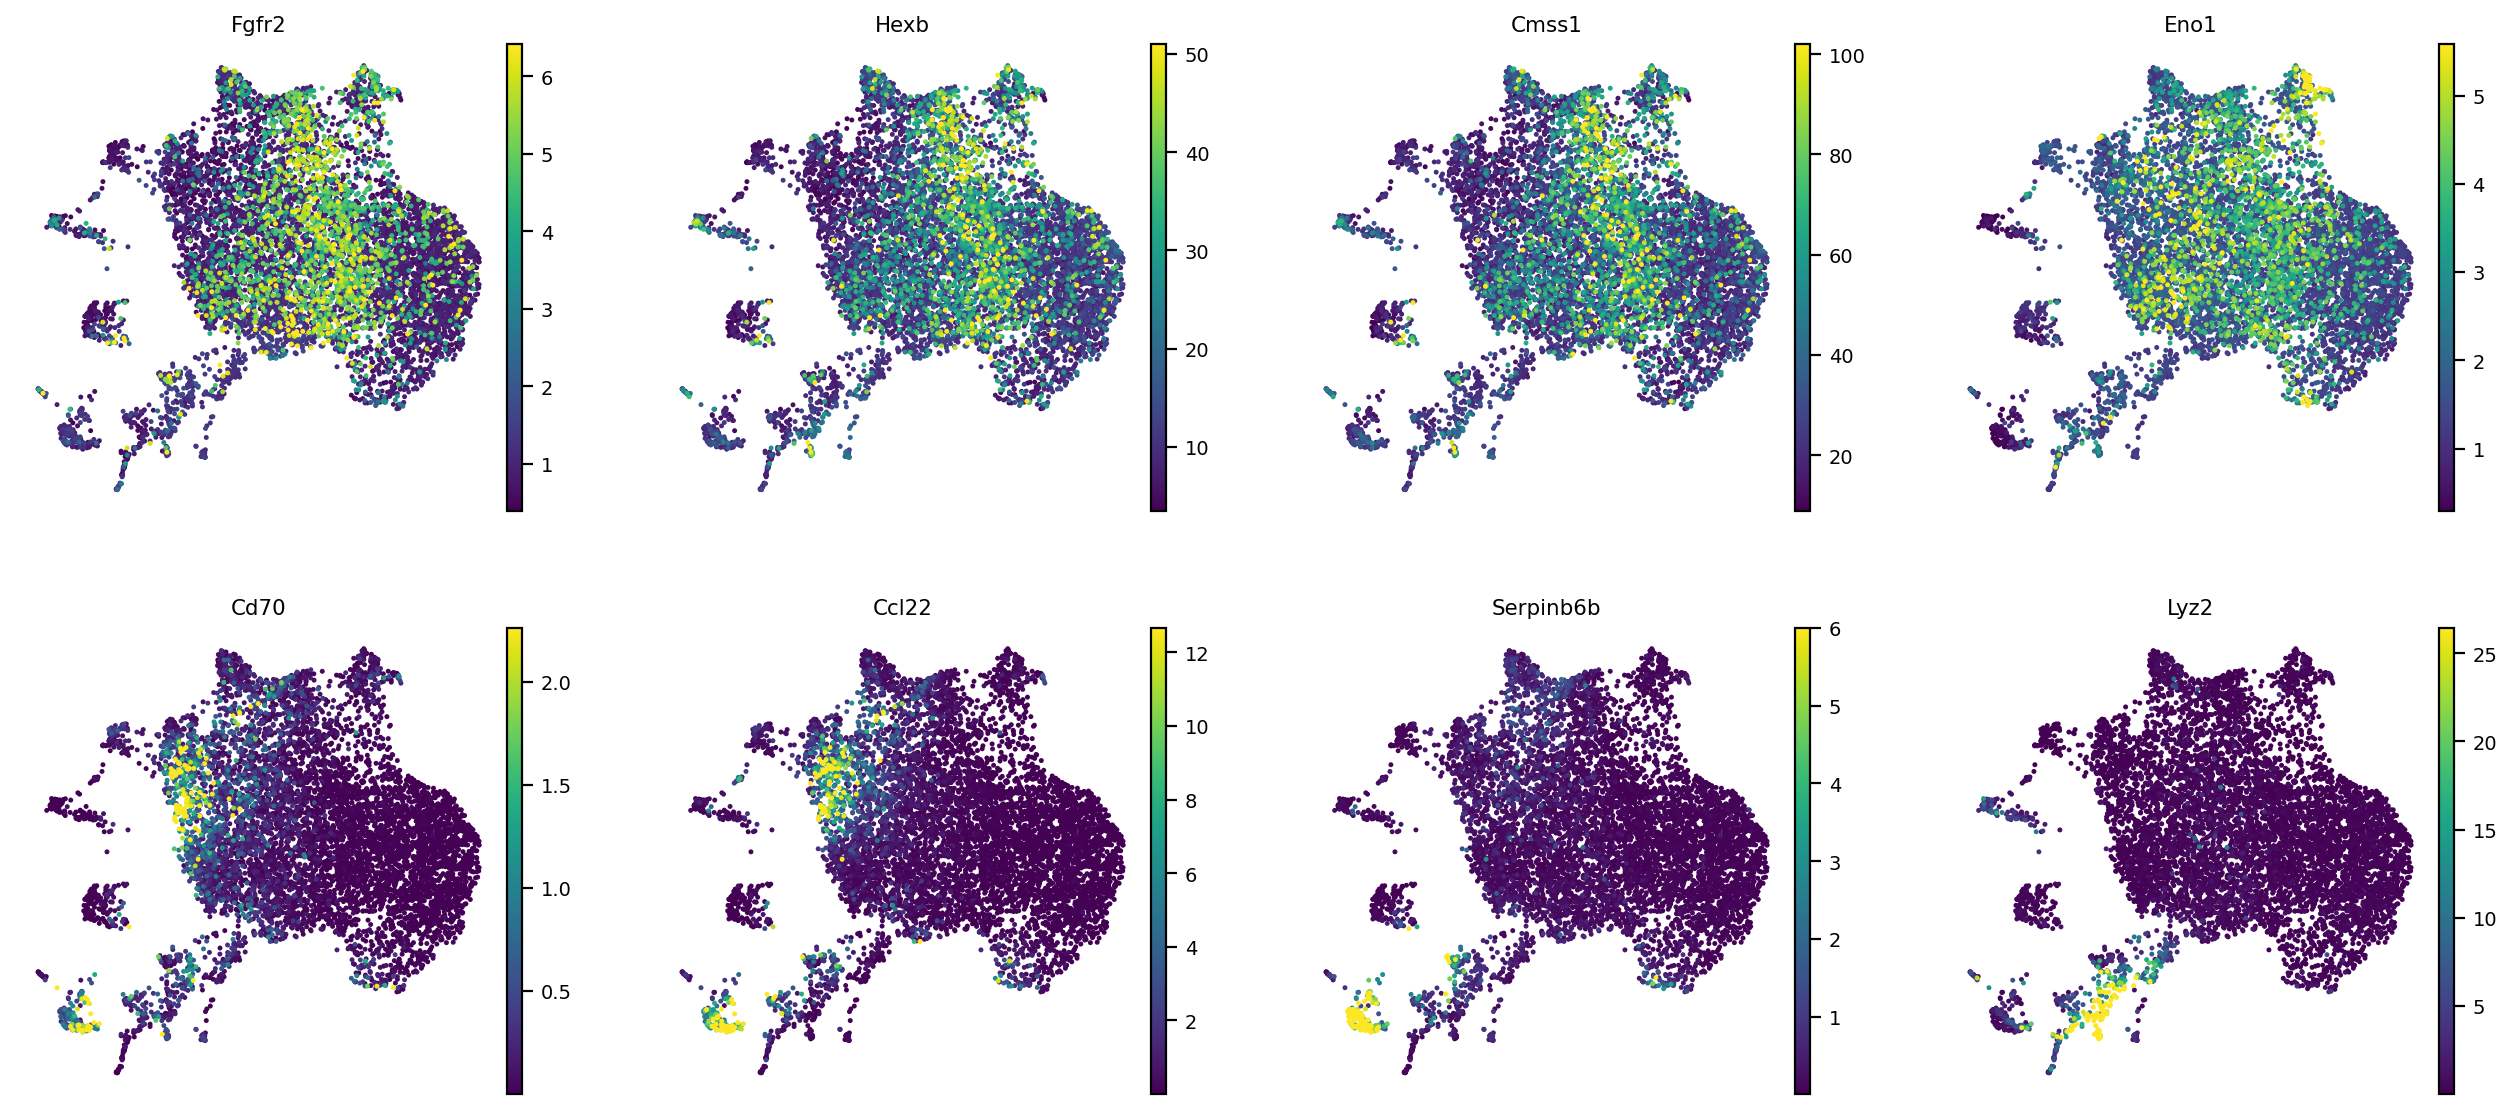

In [47]:
rna.pl.gene_embedding(
    adata,
    gene_list=["Fgfr2", "Hexb", "Cmss1", "Eno1", "Cd70", "Ccl22", "Serpinb6b", "Lyz2"],
    layer="scVI_normalized",
    s=20
)

# Volcano plots

## All genes

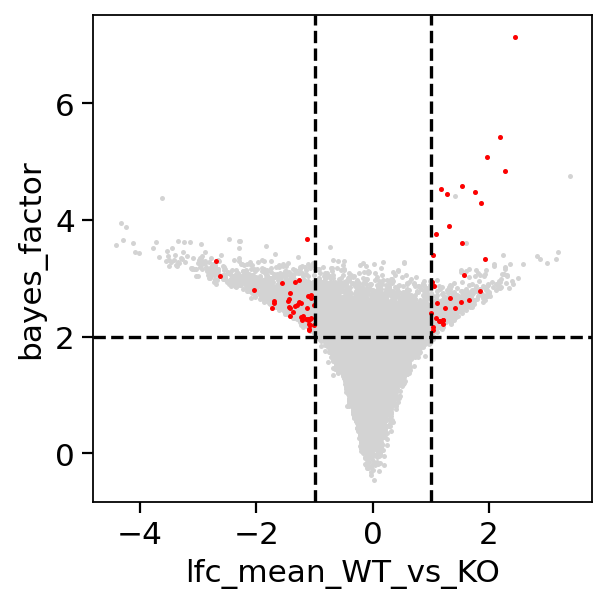

In [17]:
volcano_plot(
    allClustersDE,
    highlight_genes=filteredAllClustersDE.index,
    #label_genes=,
    # save_path="../../analysis/Paper figs/1 (Fezf2 KO)/1H_de_genes.pdf"
)

# DE TFs

In [21]:
allClustersTFs = filteredAllClustersDE[filteredAllClustersDE.index.isin(TFs)]
allClustersTFs.to_csv("../analysis/CCR6_WT_vs_KO_DE/all_clusters_filtered_TFs.csv")
len(allClustersTFs)

3

In [22]:
allClustersTFs.head(15)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Nr3c2,0.9012,0.0988,2.210630,0.000050,0.000025,0.0,0.25,1.199566,1.187066,1.362841,...,0.114603,0.076296,0.076402,0.057376,0.174299,0.104869,False,WT vs CCR6_KO,WT,CCR6_KO
Hivep3,0.9096,0.0904,2.308761,0.000013,0.000029,0.0,0.25,-1.142434,-1.176851,1.481073,...,0.091393,0.222736,0.069632,0.137825,0.112976,0.211277,False,WT vs CCR6_KO,WT,CCR6_KO
Mybl2,0.9288,0.0712,2.568400,0.000003,0.000012,0.0,0.25,-1.696114,-1.653646,2.274909,...,0.020309,0.134133,0.013540,0.066451,0.012923,0.073543,False,WT vs CCR6_KO,WT,CCR6_KO


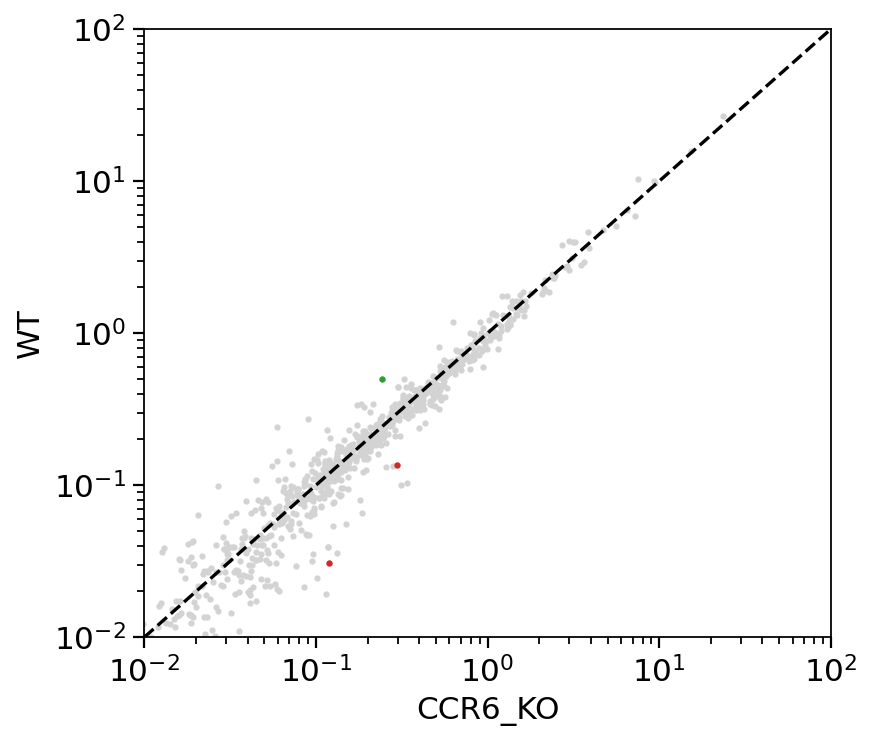

In [25]:
adata.obs["genotype"] = adata.obs.batch
genotype_gene_expression(
    adata,
    gene_list=TFs,
    genotype_list=["WT", "CCR6_KO"],
    highlight_genes=allClustersTFs.index,
    cell_type_list=None,
    # axis_lim=[10**-4, 10**2],
    # save_path="../../analysis/Paper figs/1 (Fezf2 KO)/1J_Fezf2_reg_TFs.pdf"
)